# <font color='green'>ĐỒ ÁN 3: Fake news detection
## Danh sách các thành viên và bảng phân công công việc:
| STT | Họ và tên | MSSV | Nội dung công việc | Hoàn thành |
| :--- | :---: | :---: | :---: | ---: |
| 01 | Lưu Trường Dương | 19120489 |Tiền xử lý văn bản tiếng Việt, Mô hình hóa, EDA (khám phá dữ liệu), Deploy mô hình| 100%|
| 02 | Nguyễn Phạm Quang Dũng | 19120485 |Mô hình hóa, Tiền xử lý văn bản tiếng Việt,EDA (khám phá dữ liệu), Deploy mô hình| 100% |
| 03 | Huỳnh Quốc Duy | 19120494 |Mô hình hóa, EDA (khám phá dữ liệu), Deploy mô hình, Tiền xử lý văn bản tiếng Việt| 100% |
| 04 | Phạm Đức Huy | 19120534 |EDA (khám phá dữ liệu), Tiền xử lý văn bản tiếng Việt, Mô hình hóa, Deploy mô hình| 100% |
| 05 | Lê Thành Lộc | 19120562 |Deploy mô hình, Tiền xử lý văn bản tiếng Việt, Mô hình hóa, EDA (khám phá dữ liệu)| 100% |

Link trang web streamlit đã deploy. [**Click here**](https://share.streamlit.io/nightfury1103/nm-khdl/main) <br>
Link github chứa file streamlit . [**Click here**](https://github.com/nightfury1103/NM-KHDL.git)

**Lưu ý:** Bài làm thuộc quyền sử hữu của các thành viên trong nhóm. Các thao tác chỉnh sửa góp ý cũng như trích dẫn phải được sự đồng ý của tác giả.

## Import

Import các thư viện cần thiết. Ở phần này ta sẽ sử dụng các thư viện thường gặp ở bộ môn Nhập môn Khoa Học Dữ liệu. 

In [52]:
import pandas as pd 
import re
import sys
import seaborn as sns;
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

## Dữ liệu

- Tập dữ liệu 223 record bản tin tiếng Việt, gồm 2 nhãn: 1 (tin giả) và 0 (tin thật)

In [53]:
df = pd.read_csv('data.csv')
df1 = df.copy()
df.head()

,text,domain,label
0,Thủ tướng Abe cúi đầu xin lỗi vì hành động phi...,binhluan.biz,1
1,Thủ tướng Nhật cúi đầu xin lỗi vì tinh thần ph...,www.ipick.vn,1
2,Choáng! Cơ trưởng đeo khăn quàng quẩy banh nóc...,tintucqpvn.net,1
3,Chưa bao giờ nhạc Kpop lại dễ hát đến thế!!!\n...,tintucqpvn.net,1
4,"Đại học Hutech sẽ áp dụng cải cách ""Tiếq Việt""...",www.gioitreviet.net,1


In [54]:
df['label'].value_counts()

0    123
1    100
Name: label, dtype: int64

- Dữ liệu gồm **123** tin thật và **100** tin giả.

## Tiền xử lí văn bản Tiếng Việt

### Lower case

Thực hiện chuyển đổi tất cả các mẫu về dạng lower case qua đó thuận tiện cho các bước tiếp theo.

In [55]:
df['text'] = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df.head()

,text,domain,label
0,thủ tướng abe cúi đầu xin lỗi vì hành động phi...,binhluan.biz,1
1,thủ tướng nhật cúi đầu xin lỗi vì tinh thần ph...,www.ipick.vn,1
2,choáng! cơ trưởng đeo khăn quàng quẩy banh nóc...,tintucqpvn.net,1
3,chưa bao giờ nhạc kpop lại dễ hát đến thế!!! g...,tintucqpvn.net,1
4,"đại học hutech sẽ áp dụng cải cách ""tiếq việt""...",www.gioitreviet.net,1


### Remove Stopwords

Trong câu thoại, tin tức và lời nói thường ngày thì bất kì ngôn ngữ nào cũng phải có stopwords. Việc loại bỏ các stopword là vô cùng cần thiết trong việc xử lý ngôn ngữ tự nhiên. <br>
Các cụm từ stopword được trích xuất từ file  **vietnamese_stopwords.txt** lấy từ [link github](https://github.com/stopwords/vietnamese-stopwords/blob/master/vietnamese-stopwords.txt).

Để loại bỏ stopwords ta thực hiện lần lượt 3 bước:
- Bước 1: đọc danh sách các stopwords từ link github ở trên, lưu vào list `vietnamese`
- Bước 2: sort các từ trong list `vietnamese` , viết hàm `remove_stopwords` duyệt theo thứ tự sort giảm dần để đảm bảo luôn ưu tiên xóa các stopword dài nhất có thể
- Bước 3: apply hàm `remove_stopwords`  cho cột `text` của `df`

Bước 1:

In [56]:
def get_stopwords_list(stop_file_path):
    """load stop words """
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return list(frozenset(stop_set))
vietnamese = get_stopwords_list('vietnamese_stopwords.txt')

Bước 2:

In [57]:
temp = vietnamese.copy()
temp.sort()
temp.reverse()

def remove_stopwords(text):
    text_list = text.split()
    text_len = len(text_list)
    for word in temp:
        word_list = word.split()
        word_len = len(word_list)
        for i in range(text_len + 1 - word_len):
            if text_list[i:i+word_len] == word_list:
                text_list[i:i+word_len] = [None] * word_len
    return ' '.join(t for t in text_list if t)

Bước 3:

In [58]:
df['text'] = df['text'].apply(remove_stopwords)

### Remove noise
Dùng regex để loại bỏ các kí tư gây nhiễu (HTML tag, các ký hiệu đặc biệt như @, #,...) thông qua hàm `remove_tag`

In [59]:
TAG_1 = re.compile(r'<[^>]+>')
TAG_2 = re.compile("[@#$]")

def remove_tags(text):
    text = TAG_1.sub('', text)
    return TAG_2.sub('', text)
    
df['text'] = df['text'].apply(lambda x: ' '.join(word for word in x.split() if word.isalnum()))

In [60]:
df['text'].sample()

58    thời xinh gái chẳng nét mặt xinh xắn siêu thươ...
Name: text, dtype: object

### Remove punctuation (loại bỏ dấu câu)

Các dấu câu thường ngày thường không giúp ích gì nhiều trong việc nhận diện tin thật và giả. Nên ở đây ta sẽ loại bỏ luôn các dấu câu đó.

In [61]:
df['text'] = df['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [62]:
df['text'][0]

'thủ tướng abe cúi đầu lỗi hành động phi thể thao tuyển nhật sankei thủ tướng nhật shinzo abe công khai gửi lỗi nhật hoàng toàn dân tinh thần thi đấu phi thể thao đội tuyển nhật world cup tối lượt trận vòng bảng world cup nhật phụ đội thua nhật vòng thẻ phạt thủ tướng nhật shinzo abe cúi đầu tinh thần võ sĩ đạo đội tuyển nhật hành động tinh thần thượng võ thi đấu world trích bất bình toàn hình ảnh kiên cường dân nhật đấu trường quốc đứng thành trách nhiệm gửi lỗi sâu sắc nhân abe cúi đầu trách nhiệm nhật nổi tiếng tinh trách nhiệm chất võ sĩ đội tuyển áo xanh mệnh danh nhật trích dội hâm mộ bóng đá lối bóng tiêu cố tình câu vé đi cụ phút trận vòng bảng trận colombia thắng senegal tỷ tỉ tương cầu thủ nhật hề gỡ cầu thủ nhật vui vẻ trận thua lan vé vòng 16 world cup fifa fair quy định 1 thẻ vàng 2 thẻ vàng thành thẻ đỏ thẻ đỏ nhật 4 thẻ vàng senegal sợ lãnh thẻ vàng nhật giết chết trận đấu phút liên tục chuyền bóng sân 5 phút cầu thủ nhật bóng sân đối bất chấp la huýt sáo cđv thầy trò hl

## Khám phá dữ liệu

### Ý nghĩa của từng trường thông tin


- `text` chứa nội dung của bài báo
- `domain` chứa nguồn của bài báo 
- `label` để phân loại bài báo đúng hay sai, 1 là Fake và 0 là Real

### Kiểm tra dữ liệu bị thiếu, sai kiểu dữ liệu

Dữ liệu có bị thiếu?

In [63]:
df.isna().sum()

text      0
domain    0
label     0
dtype: int64

Kiểu dữ liệu đã đúng hết chưa?

In [64]:
df.dtypes

text      object
domain    object
label      int64
dtype: object

### Kiểm tra phân bố class có chênh lệch hay không

Kiểm tra số lượng label Fake và label Real

In [65]:
ax = df.label.value_counts()
ax

0    123
1    100
Name: label, dtype: int64

Biểu đồ so sánh 2 label

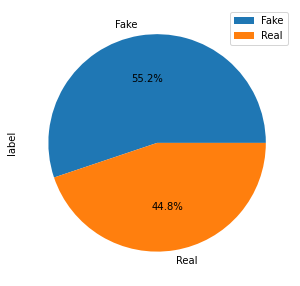

In [66]:
ax = ax.to_frame()

ax.index = ['Fake','Real']
ax.plot.pie(y='label',figsize=(5,5),autopct='%1.1f%%')
plt.show()

Như ta có thể thây số lượng label Fake và label Real không có quá chênh lệch, có thể dễ để mang lại hiệu quả cao trong quá trình học máy

### Các thông tin thống kê của văn bản

- Chiều dài mỗi record
- Số ký tự ở mỗi record
- Số câu ở mỗi record

In [67]:
df1['record_length'] = df1['text'].apply(lambda x:len(x))
df1['word_count'] = df1["text"].apply(lambda x: len(str(x).split(" ")))
df1['sentence_count'] = df["text"].apply(lambda x: len(str(x).split(".")))
df1.drop(columns="domain").head()

,text,label,record_length,word_count,sentence_count
0,Thủ tướng Abe cúi đầu xin lỗi vì hành động phi...,1,2244,482,1
1,Thủ tướng Nhật cúi đầu xin lỗi vì tinh thần ph...,1,884,188,1
2,Choáng! Cơ trưởng đeo khăn quàng quẩy banh nóc...,1,1232,240,1
3,Chưa bao giờ nhạc Kpop lại dễ hát đến thế!!!\n...,1,3093,671,1
4,"Đại học Hutech sẽ áp dụng cải cách ""Tiếq Việt""...",1,8804,1943,1


Tìm hiểu thêm về số lượng kí tự

1. Xem các thông số cơ bản của cột `word count`

In [68]:
df1['word_count'].describe()

count     223.000000
mean      552.686099
std       393.414288
min        67.000000
25%       281.000000
50%       438.000000
75%       718.000000
max      2266.000000
Name: word_count, dtype: float64

2. Biểu đồ phân bố của `word_count`

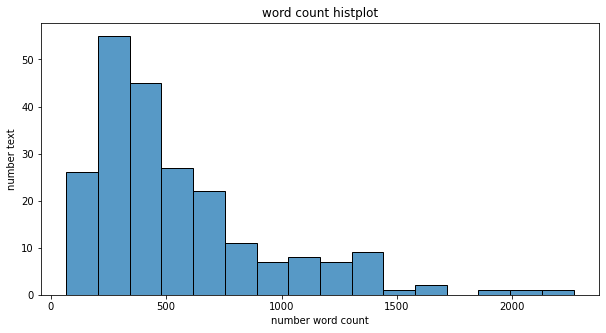

In [69]:
ax = sns.histplot(df1['word_count'])
ax.set(xlabel = 'number word count',ylabel = 'number text', title='word count histplot');

## Mô hình hóa 

### Tách dữ liệu

Ta thực hiện các thao tác tách dữ liệu thành hai tập train và test với tỉ lệ là 75% và 25% (tỉ lệ thông thường) bằng hàm `train_test_split`

In [70]:
x = df["text"]
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(x, y, 
                                                  random_state=42, 
                                                  test_size=0.25
                                                     , shuffle=True
                                                   )

### Chuyển đổi dữ liệu

Sau khi thực hiện tác tách dữ liệu bước tiếp theo ta sẽ thực hiện vector hóa các tập trainning và tập test. 
Ở phần này ta sẽ sử dụng mô hình vector hóa có sẵn là `TfidfVectorizer`.Một phương thức thống kê được biết đến rộng rãi nhất để xác định độ quan trọng của một từ trong đoạn văn bản trong một tập nhiều đoạn văn bản khác nhau. Nó thường được sử dụng như một trọng số trong việc khai phá dữ liệu văn bản. TF-IDF chuyển đổi dạng biểu diễn văn bản thành dạng không gian vector (VSM), hoặc thành những vector thưa thớt.

In [71]:
tfidf = TfidfVectorizer(min_df=2,max_df=0.8,  max_features=None,ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1)
tftrain = tfidf.fit_transform(X_train)
tftest = tfidf.transform(X_test)

### Đồ thị hóa dữ liệu


Nhìn chung ta thấy dữ liệu là dạng có nhãn mà nhãn này được phân thành hai lớp rõ rệt . Do đó, ở đây ta sẽ thử sử dụng PCA và xem xét xem liệu dữ liệu có nằm ở hai phía rõ rệt nhau hay không. Từ đó ta sẽ lựa chọn mô hình phù hợp cho bài toán này.
Do đó, ta sẽ thử sử dụng PCA để giảm chiều giữa liệu thành dữ liệu 2 chiều để có thể mô hình hóa dữ liệu ở dạng này.

In [72]:
# 1. Choose the model class
from sklearn.decomposition import TruncatedSVD
# 2. Instantiate the model with hyperparameters
model = TruncatedSVD(n_components=2)
# 3. fit to data. Notice y not specified!
model.fit(tftrain)
# 4. tranform the data to two dimensions
X_2D = model.transform(tftrain)

In [73]:
visualization = pd.DataFrame(y_train)
visualization['SVD1'] = X_2D[:, 0]
visualization['SVD2'] = X_2D[:, 1]

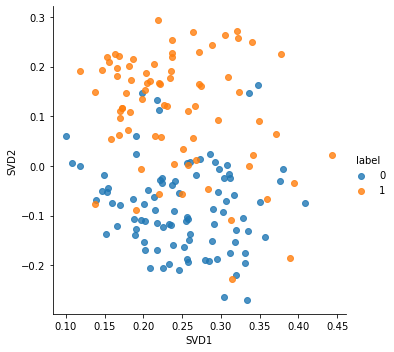

In [74]:
sns.lmplot(x="SVD1", y="SVD2", hue='label', 
           data=visualization, fit_reg=False);

**Kết luận:** Nhìn vào đồ thị thì có vẻ dữ liệu phân lớp về hai phía đồ thị rất tốt. Dữ liệu chỉ có hai nhãn nên độ phức tạp trong đồ thị cũng không quá cao. Qua đó ta sẽ lựa chọn các mô hình học máy phù hợp ở phần sau.

### Training bằng các mô hình học máy

#### Import các thư viện cho học máy

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics
import pickle
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import itertools

#### Xây dựng confusion matrix để đánh giá hiệu suất của các thuật toán

- Vì độ đo accuracy thông thường chỉ cho chúng ta biết được bao nhiêu phần trăm lượng dữ liệu được phân loại đúng mà không chỉ ra được cụ thể mỗi loại được phân loại như thế nào, lớp nào được phân loại đúng nhiều nhất, và dữ liệu thuộc lớp nào thường bị phân loại nhầm vào lớp khác. Để có thể đánh giá được các giá trị này, chúng ta sử dụng một ma trận được gọi là **confusion matrix**.
- Confusion Matrix là một ma trận vuông với kích thước mỗi chiều bằng số lượng lớp dữ liệu. Giá trị tại hàng thứ i, cột thứ j là số lượng điểm lẽ ra thuộc vào class i nhưng lại được dự đoán là thuộc vào class j
- Như với tập dữ liệu đang xét thì 2 class sẽ là **'Fake'** và **'News'**

In [76]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [77]:
accuracy_dict = {}

#### Logistic Regession

- Logisitc Regression là một trong những thuật toán phân loại phổ biến nhất và cũng là một thuật toán khá đơn giản.
- Với việc sử dụng để phân loại văn bản với đầu ra dạng nhị phân (Fake news/ Real news) thì mô hình Logistic Regession được sử dụng bởi nó cho thấy được tính trực quan để phân loại vấn đề thành nhị phân.

Accuracy:   0.911
Confusion matrix, without normalization


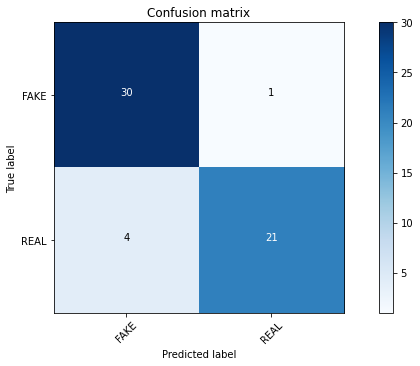

In [78]:
model = LogisticRegression()
model.fit(tftrain,y_train)

pred = model.predict(tftest)
score = accuracy_score(y_test, pred)
accuracy_dict['Logistic Regession'] = score
print("Accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

**Nhận xét:** Từ confusion matrix ta có thể thấy có tổng cộng 31 Fake news nhưng đã có 1 phân loại nhầm vào Real news và có 25 Real news nhưng cũng đã có 4 tin được phân loại vào Fake news. Từ đó ta có thể tính được độ chính xác $ \frac{(21+30)}{56} \approx 0.911$.
Với việc đầu ra dạng nhị phân như bài toán Fake news thì Logistic Regession chạy khá tốt mặc dù đây là mô hình tương đối là đơn giản.

- Tạo pickle cho việc deploy mô hình bằng streamlit.

In [79]:
model_pipe = Pipeline([('tfidf',tfidf),('log',model)])
model_pipe.fit(X_train,y_train)

### Create a Pickle file using serialization 
pickle_out = open("log_classifier.pkl","wb")
pickle.dump(model_pipe, pickle_out)
pickle_out.close()

#### Naive-Bayes

- Thuật toán Naive-Bayes là một thuật toán phân loại cho các vấn đề phân loại nhị phân (hai lớp) và đa lớp. Kỹ thuật này dễ hiểu nhất khi được mô tả bằng các giá trị đầu vào nhị phân hoặc phân loại.
- ```Multinominal Naive Bayes``` là một mô hình được chủ yếu sử dụng trong việc phân loại văn bản mà feature vectors được tính bằng ```Bags of Word``` rất thích hợp trong bài toán fake news.

Accuracy:   0.911
Confusion matrix, without normalization


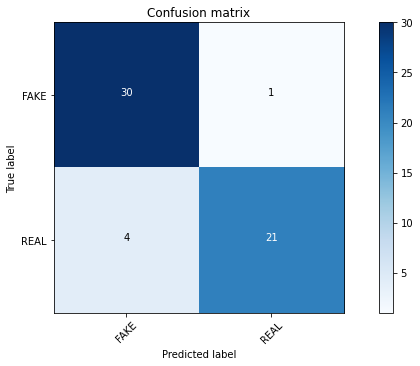

In [80]:
classifier=MultinomialNB()
classifier.fit(tftrain,y_train)
pred = classifier.predict(tftest)
score = accuracy_score(y_test, pred)
print("Accuracy:   %0.3f" % score)
accuracy_dict['Naive Bayes'] = score
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

**Nhận xét:** kết quả chạy của Naive Bayes khá tương tự với Logistic Regession, ta vẫn có độ chính xác là $ \frac{(21+30)}{56} \approx 0.911$. Multinominal Naive Bayes thích hợp cho việc chạy trên cả bộ dữ liệu lớn hay nhỏ đều có thể đưa ra kết quả với độ chính xác cao.

- Tạo pickle cho việc deploy mô hình bằng streamlit.

In [81]:
model_pipe = Pipeline([('tfidf',tfidf),('naive_bayes',classifier)])
model_pipe.fit(X_train,y_train)

### Create a Pickle file using serialization 

pickle_out = open("naivebayes_classifier.pkl","wb")
pickle.dump(model_pipe, pickle_out)
pickle_out.close()

#### K Neighbors

Thuật toán K Neighbors là một kĩ thuật học có giám sát (supervised learning) dùng để phân loại quan sát mới bằng cách tìm điểm tương đồng giữa quan sát mới này với dữ liệu sẵn có. Với bộ dữ liệu ít có điểm nhiễu(trên đồ thị đã PCA giảm chiều) thì K Neighbors cũng là một thuật toán hợp lí với độ phức tạp của quá trình training là 0.
- Cần chọn giá trị `n_neighbors` phù hợp với tập dữ liệu. Với tập dữ liệu ta chọn n_neighbors = 3
- Xác định `thước đo đúng để tính khoảng cách` giữa đối tượng cần phân lớp với các đối tượng còn lại trong cơ sở dữ liệu. Ta chọn thước đo là khoảng cách minkowski

Accuracy:   0.929
Confusion matrix, without normalization


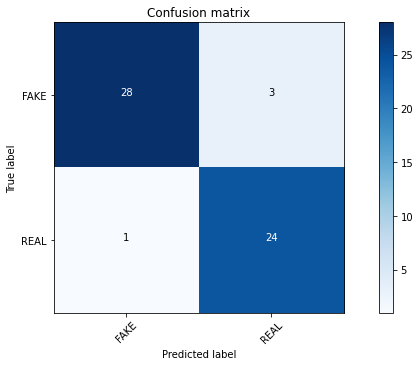

In [82]:
classifier= KNeighborsClassifier(n_neighbors=3,weights='uniform',metric='minkowski')

classifier.fit(tftrain,y_train)
pred = classifier.predict(tftest)
score = accuracy_score(y_test, pred)
accuracy_dict['K Neighbors'] = score
print("Accuracy:   %0.3f" % score)

cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

**Nhận xét:** Kết quả cho thấy độ chính xác của K Neighbors lên đến $ \frac{(28+24)}{56} \approx 0.929$. Nhờ vào việc chọn giá trị tham số ```n_neighbors``` phù hợp *(=3)* cộng thêm bộ dữ liệu không có điểm nhiễu thì mô hình đã cho ra kết quả chạy tối ưu.

- Tạo pickle cho việc deploy mô hình bằng streamlit.

In [83]:
model_pipe = Pipeline([('tfidf',tfidf),('Kneighbor',classifier)])
model_pipe.fit(X_train,y_train)

### Create a Pickle file using serialization 

pickle_out = open("Kneighbor_classifier.pkl","wb")
pickle.dump(model_pipe, pickle_out)
pickle_out.close()

#### Random Forest

- Random Forest là một mô hình học tập có giám sát. Đây là một nâng cấp của Decision Tree, bao gồm một số lượng lớn cây quyết định hoạt động riêng lẻ để dự đoán kết quả của một lớp.

Accuracy:   0.893
Confusion matrix, without normalization


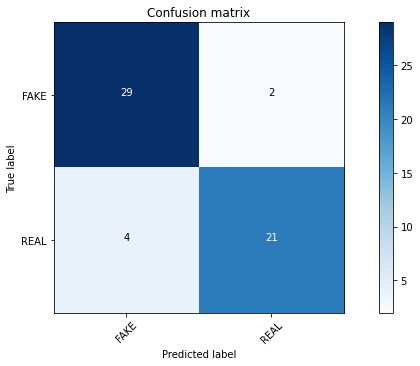

In [84]:
classifier = RandomForestClassifier(random_state=0)
classifier.fit(tftrain, y_train)
pred = classifier.predict(tftest)
score = accuracy_score(y_test, pred)
accuracy_dict['Random Forest'] = score
print("Accuracy:   %0.3f" % score)

cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

**Nhận xét:** Với độ chính xác $ \frac{(29+21)}{56} \approx 0.893$ thì Random Forest cũng là một mô hình tốt để sử dụng trong việc phát hiện Fake news, và có thể sử dụng hiệu quả ở các tập dữ liệu lớn.

- Tạo pickle cho việc deploy mô hình bằng streamlit.

In [85]:
model_pipe = Pipeline([('tfidf',tfidf),('RandomForest',classifier)])
model_pipe.fit(X_train,y_train)

### Create a Pickle file using serialization 
pickle_out = open("RandomForest_classifier.pkl","wb")
pickle.dump(model_pipe, pickle_out)
pickle_out.close()

#### Deep Learning: Neural Network

Ngày nay, deep learning đang nổi lên như một nhóm thuật toán dựa hệ thống mạng neuron (Neural Network) để giải các bài toán thông thường với hiệu suất cao hơn cả machine learning.
Với tập dữ liệu này, ta sẽ sử dụng mô hình  MLP (Multilayer Perceptron) để phân lớp. Các siêu tham số ban đầu là :
- `hidden_layer_sizes`=(50): sử dụng 1 hidden layer với 50 neuron
- `activation`='relu': chọn hàm relu (f(x) = max(0, x)) làm hàm kích hoạt
- `solver`='lbfgs' :  hàm tinh chỉnh weight là lbfgs vì nó hội tụ nhanh hơn và hoạt động tốt hơn đối với tập dữ liệu nhỏ
- `max_iter`=10000: số lần lặp tối đa nếu chưa hội tụ

- Thêm siêu tham số ``alpha`` từ **0-100** để tìm ra giá trị Accuracy tốt nhất.


In [86]:
train_accs = []
val_accs = []
alphas = [0,0.01,0.1, 1, 10, 100]
best_val_acc = 0
best_alpha = None
get_parameters = []
for alpha in alphas:
    model = MLPClassifier(hidden_layer_sizes=(50), activation='relu', solver='lbfgs', random_state=0, 
                            max_iter=10000, alpha=alpha)
    model.fit(tftrain, y_train)
    val_y_predict = model.predict(tftest)
    # calculate accuracy
    val_err = model.score(tftest, y_test)
    val_accs.append(val_err)
    # get alpha and num_top_cp_values
    get_parameters.append((alpha))
best_val_acc = max(val_accs)
best_alpha = get_parameters[val_accs.index(max(val_accs))]
print(f'Best accuracy score is {round(best_val_acc,6)} with alpha= {best_alpha}')
'Finish!'

Best accuracy score is 0.928571 with alpha= 0.01


'Finish!'

- Training với siêu tham số alpha tốt nhất.

Accuracy:   0.929
Confusion matrix, without normalization


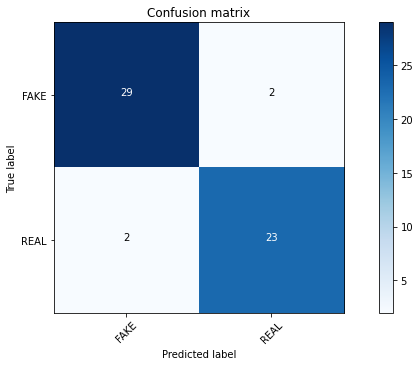

In [87]:
classifier=MLPClassifier(alpha=best_alpha,hidden_layer_sizes=(50), activation='relu', solver='lbfgs', random_state=0, max_iter=10000)

classifier.fit(tftrain,y_train)
pred = classifier.predict(tftest)
score = accuracy_score(y_test, pred)
accuracy_dict['Neurual Network'] = score
print("Accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

**Nhận xét:** Là mô hình kì vọng nhất trong tất cả 5 mô hình chúng em đưa ra. Không phải ngẫu nhiên mà mô hình này được đưa vào báo cáo và được xếp ở cuối cùng trong phần này. Kết quả ở mô hình này qua các lần test đều cho ra kết quả thường là cao nhất trong 5 mô hình. Dựa vào kết quả của mỗi lần test thì phải nói đây là mô hình có độ chính xác ổn định nhất. Mặc dù vậy do dữ liệu khi chia là ngẫu nhiên nên không thể phủ nhận là sẽ có trường hợp mô hình chạy không phải là tốt nhất và thời gian chạy của mô hình này cũng là lâu nhất. Do đó, đối với tập dữ liệu lớn hơn thì nhóm em sẽ có chiến lược khác với mô hình này hoặc là sử dụng một mô hình học máy khác. 

- Tạo pickle cho việc deploy mô hình bằng streamlit.

In [88]:
model_pipe = Pipeline([('tfidf',tfidf),('mlp',classifier)])
model_pipe.fit(X_train,y_train)

### Create a Pickle file using serialization 
pickle_out = open("mlp_classifier.pkl","wb")
pickle.dump(model_pipe, pickle_out)
pickle_out.close()

#### Tổng quát:

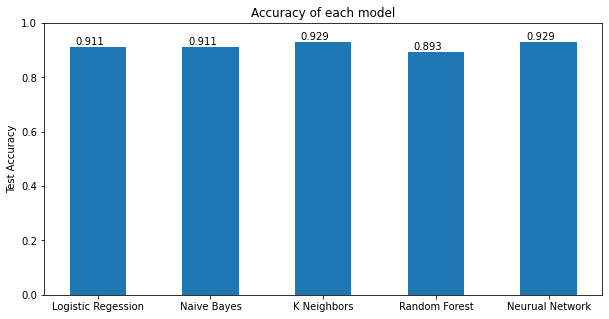

In [89]:
x = accuracy_dict.keys()
y = accuracy_dict.values()
bars = plt.bar(x,y,width=0.5)
plt.ylim([0.0,1.0])

xlocs, xlabs = plt.xticks()
xlocs=[i for i in x]
xlabs=[i for i in x]
plt.ylabel('Test Accuracy')
plt.xticks(xlocs, xlabs)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x()+ 0.05, yval + .01, round(yval,3))
plt.rcParams["figure.figsize"] = [10,5]
plt.title("Accuracy of each model")
plt.show()